<div style="text-align:center"><span style="color:#800000; font-family:Georgia; font-size:2.4em;"> Proyecto de Aplicación Profesional </span></div>

<img style="float: right; margin: auto;" src="https://www.ambulante.org/wp-content/uploads/2019/03/logos_web_Jalisco_ITESOJesuita.png" width="350" height="220" />

> <b> <p style = "font-family: Palatino; font-size:0.8em; color: #008080;" > Métrica de Precios </p> <b/>

<i> <p style = "font-family: Calibri Light; font-size:1.1em;color:black;"> Caracteristicas de Series de Tiempo </p> <i/>

<span style="color:#004A94; font-family:Georgia; font-size:1.7em;"> Box-Jenkins Method </span> [LINK]('https://machinelearningmastery.com/gentle-introduction-box-jenkins-method-time-series-forecasting/')


The approach starts with the assumption that the process that generated the time series can be approximated using an ARMA model if it is stationary or an ARIMA model if it is non-stationary.

- **Identification.** Use the data and all related information to help select a sub-class of model that may best summarize the data.
> 1. Assess whether the time series is stationary, and if not, how many differences are required to make it stationary.
>> **1.1 Differencing**
>> - Unit Root Tests. Use unit root statistical tests on the time series to determine whether or not it is stationary. Repeat after each round of differencing.
>> - Avoid over differencing. Differencing the time series more than is required can result in the addition of extra serial correlation and additional complexity.
>>
>> **1.2 Configuring AR and MA**
>> - Autocorrelation Function (ACF). The plot summarizes the correlation of an observation with lag values. The x-axis shows the lag and the y-axis shows the correlation coefficient between -1 and 1 for negative and positive correlation.
>> - Partial Autocorrelation Function (PACF). The plot summarizes the correlations for an observation with lag values that is not accounted for by prior lagged observations.
> 2. Identify the parameters of an ARMA model for the data.
>> Estimation involves using numerical methods to minimize a loss or error term.

- **Estimation.** Use the data to train the parameters of the model (i.e. the coefficients).
> Estimation involves using numerical methods to minimize a loss or error term.

- **Diagnostic Checking.** Evaluate the fitted model in the context of the available data and check for areas where the model may be improved
> To look for evidence that the model is not a good fit for the data.
>> **3.1 Overfitting** 
>> - The first check is to check whether the model overfits the data. Generally, this means that the model is more complex than it needs to be and captures random noise in the training data.
>> - This is a problem for time series forecasting because it negatively impacts the ability of the model to generalize, resulting in poor forecast performance on out of sample data.
>>
>> **3.2 Residual Errors**
>> - A review of the distribution of errors can help tease out bias in the model. The errors from an ideal model would resemble white noise, that is a Gaussian distribution with a mean of zero and a symmetrical variance.
>> - For this, you may use density plots, histograms, and Q-Q plots that compare the distribution of errors to the expected distribution. A non-Gaussian distribution may suggest an opportunity for data pre-processing. A skew in the distribution or a non-zero mean may suggest a bias in forecasts that may be correct.


In [9]:
# Importar librerias y funciones
import datos as dat
import entradas as ent
# --------------------------- #
import numpy as np
from statsmodels.tsa.stattools import  adfuller #prueba de estacionariedad
from statsmodels.tsa.stattools import pacf,acf
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import shapiro
import matplotlib.pyplot as plt

- Se trabajará con las diferencias de los precios para tener los datos en porcentajes y se puedan comparar entre productos (diferencias de productos)
- Se agrupa por clase sacanado la mediana de todo el conjunto
> - Se enseñará en el dash por clases(15), pero a su vez el analisis es por grupos (32)
- Función BoxJenkins automatizada

In [44]:
# Leer datos
df_prices_or = dat.read_file(ent.path_data_prices, ent.sheet_data_prices)

# Dividir en categorias de sectores
categorias = list(df_prices_or.groupby('División'))

sct = 0
# Nombre de sector
print(categorias[sct][0])

# DataFrame con los datos promedio del sector 0 (Alimentos)
datos = (categorias[sct][1]).mean()[2:]
#datos.rename(categorias[sct][0], inplace=True)

# Indice de numeros
datos = datos.reset_index(drop=False)

# Reacomodar los datos de mas viejo a mas actual
datos.sort_index(ascending=False, inplace=True)
# Reiniciar indice (0-21)
serie_tiempo = datos.reset_index(drop=True)

serie_tiempo.head()

1. Alimentos, bebidas y tabaco


,index,0
0,ago 2018,96.497137
1,sep 2018,96.559798
2,oct 2018,97.088790
3,nov 2018,90.746811
4,dic 2018,91.320264


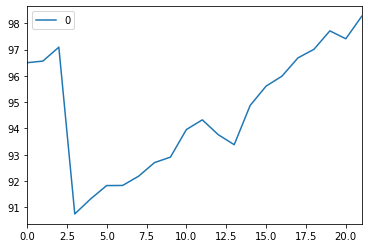

In [45]:
serie_tiempo.plot()

<span style="color:#516D6E; font-family:Georgia; font-size:1.4em;"> Prueba de estacionariedad </span>

Una serie de tiempo es estacionaria cuando la media y la variabilidad se mantienen constantes a lo largo del tiempo, es decir, no es en función del tiempo; y además, no presenta tendencia

-----

<span style="color:#29AECE; font-family:Georgia; font-size:1.2em;"> Prueba de  Dicky-Fuller aumentada </span> - [LINK]('https://es.wikipedia.org/wiki/Prueba_de_Dickey-Fuller_aumentada')

En estadística y econometría, una prueba de Dickey-Fuller aumentada (ADF) es una prueba de raíz unitaria para una muestra de una serie de tiempo. Es una versión aumentada de la prueba Dickey-Fuller para un conjunto más amplio y más complejo de modelos de series de tiempo. La estadística Dickey-Fuller Aumentada (ADF), utilizada en la prueba, es un número negativo. Cuanto más negativo es, más fuerte es el rechazo de la hipótesis nula de que existe una raíz unitaria para un cierto nivel de confianza

>Ho: No es estacionaria (tiene unit-root)
>
>Hi: Es estacionaria (No tiene raiz unitaria)

Aceptar Ho si: 
p_value > 0.05

- [adfuller]('https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html')

In [48]:
def check_stationarity(data):
    # Usar dicky fuller
    test_results = adfuller(data)
    
    if test_results[0] < 0 and test_results[1] <= 0.05:
        result = True
    else:
        result = False
    results = {'Resultado': result,
               'Test stadisctic': test_results[0],
               'P-value': test_results[1]
               }
    out=results
    if test_results[1]>0.01:
        data_d1 = data.diff().dropna()
        results_d1 = adfuller(data_d1)
        if results_d1[0] < 0 and results_d1[1] <= 0.01:

            results_d1 = {'Resultado':True,
                          'Test stadistic':results_d1[0],
                          'P-value':results_d1[1]

            }
        out={'Datos originales': results,
             'Primera diferencia': results_d1}
    return out
    #return test_results

In [47]:
check_stationarity(serie_tiempo[0])

(1.1221500532266893,
 0.9954013006159506,
 8,
 13,
 {'1%': -4.068853732362312,
  '5%': -3.1271488757396453,
  '10%': -2.7017297633136095},
 18.412168936443503)

In [49]:
# OUT
check_stationarity(serie_tiempo[0])

{'Datos originales': {'Resultado': False,
  'Test stadisctic': 1.1221500532266893,
  'P-value': 0.9954013006159506},
 'Primera diferencia': (-3.132441461155261,
  0.024243682563541605,
  1,
  19,
  {'1%': -3.8326031418574136,
   '5%': -3.0312271701414204,
   '10%': -2.655519584487535},
  24.93077239634729)}